# IBM Data Science Professional Certificate - Capstone Final Project - Oscar Antunes
##### 
### Analysis of Düsseldorf boroughs, Germany
##### 
#### Webscraping for  Boroughs, Houses available, Housing prices, Habitants, Venues
##### 

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)


In [28]:
# Import required libraries for scrapping
import urllib.request
from bs4 import BeautifulSoup
import smtplib
import json # library to handle JSON files
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

import requests # library to handle requests


import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Regular Expressions to collect the addresses
import re

# Get the same number of District cells as Boroughs
from itertools import chain

# convert an address into latitude and longitude values
from geopy.geocoders import Nominatim 


# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# import k-means from clustering stage
from sklearn.cluster import KMeans

# map rendering library
import folium

# Class object has been created to store the credentials for safekeeping
import credentials_oa_outlk

print('Libraries imported.')

Libraries imported.


# 
## Getting the Boroughs

In [2]:
url_wiki = 'https://de.wikipedia.org/wiki/Liste_der_Stadtbezirke_von_D%C3%BCsseldorf'

page = requests.get(url_wiki)
# Parsing through the URL
soup = BeautifulSoup(page.content, 'html.parser')
print("Data parsed.")

# Identify the table to scrap
right_table = soup.find('table', class_ = 'wikitable sortable')
print("Table located.")

Data parsed.
Table located.


# 
## Assigning Districts and Boroughs to DataFrame

In [3]:
# SET THE DATAFRAME COLUMNS || CREATE EMPTY DATAFRAME WITH THE SAME STRUCTURE OF THE ORIGINAL
column_names = ['District','Borough','Fläche','Einwohner','Bewölkerungsdichte','Bezirkvorsteher','K','Karte']
df = pd.DataFrame(columns = column_names)

#####################################################
# LOAD OF THE DATAFRAME || CLEAR TO THE 2 COLUMNS NEEDEED
for tr_cell in right_table.find_all('tr'):
    row_data = []
    for td_cell in tr_cell.find_all('td'):
        row_data.append(td_cell.text.rstrip())
        
    if len(row_data)>0:
        df.loc[len(df)] = row_data
        
df = df[['District', 'Borough']]
print(df.head(2),'\n')

#####################################################
# REMOVE NUMERIC DIGITS FROM THE BOROUGHS
df.set_index(['District', 'Borough'])  
df = df.replace(regex=r'[0-9]+', value=',')

# As the numeric digit has been removed from the District Column, 
# we need to add the number of each district as per the current index 
district_numb = ['1','2','3','4','5','6','7','8','9','10']
df['district_numb'] = district_numb

print(df.head(2))

           District                                            Borough
0  Stadtbezirk 1[1]  011 Altstadt012 Carlstadt013 Stadtmitte014 Pem...
1  Stadtbezirk 2[2]     021 Flingern Süd022 Flingern Nord023 Düsseltal 

           District                                            Borough  \
0  Stadtbezirk ,[,]  , Altstadt, Carlstadt, Stadtmitte, Pempelfort,...   
1  Stadtbezirk ,[,]           , Flingern Süd, Flingern Nord, Düsseltal   

  district_numb  
0             1  
1             2  


In [4]:
### Get several District cells for each Borough
# return list from series of comma-separated strings
def chainer(s):
    return list(chain.from_iterable(s.str.split(', ')))

# calculate lengths of splits
lens = df['Borough'].str.split(', ').map(len)

# create new dataframe, repeating or chaining as appropriate
res = pd.DataFrame({'District': np.repeat(df['District'], lens),
                    'Borough': chainer(df['Borough']),
                    'district_numb': np.repeat(df['district_numb'], lens)})
# Strip empty cells ""
res = res[res['Borough'].str.strip().astype(bool)]

In [5]:
# Concatenate the District to include the Number for each District
res['Dis'] = res['District'].str[:11] 
res['District'] = res['Dis']+' '+res['district_numb']

# Finalize the DataFrame with Districts and Boroughs of Düsseldorf
df_boroughs = res[['District','Borough']]
df_boroughs = df_boroughs.reset_index(drop=True)


print('Scraping of Districts and Boroughs completed!\n')
print(df_boroughs.head(2))

Scraping of Districts and Boroughs completed!

        District    Borough
0  Stadtbezirk 1   Altstadt
1  Stadtbezirk 1  Carlstadt


#### 
## Getting the Coordinates for the city of Düsseldorf

In [6]:
# Getting the Coordinates for Düsseldorf

address = 'Düsseldorf, NRW'

geolocator = Nominatim(user_agent="duesseldorf_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Düsseldorf are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Düsseldorf are 51.2254018, 6.7763137.


In [7]:
city = 'Düsseldorf, Germany'
boroughs  = df_boroughs['Borough']
coord = {'latitude':[],'longitude':[]}
for borough in boroughs:
    address = borough + ', ' + city
    location = geolocator.geocode(address)
    lat = location.latitude
    coord['latitude'].append(lat)
    lng = location.longitude
    coord['longitude'] .append(lng)
    
    print(address, lat, lng)

Altstadt, Düsseldorf, Germany 51.2259125 6.7735672
Carlstadt, Düsseldorf, Germany 51.2221416 6.7733942
Stadtmitte, Düsseldorf, Germany 51.2219385 6.7844229
Pempelfort, Düsseldorf, Germany 51.2396009 6.7796845
Derendorf, Düsseldorf, Germany 51.2445487 6.7922488
Golzheim, Düsseldorf, Germany 51.2507945 6.7599633
Flingern Süd, Düsseldorf, Germany 51.2210094 6.8100603
Flingern Nord, Düsseldorf, Germany 51.2313815 6.8132378
Düsseltal, Düsseldorf, Germany 51.2378412 6.812116
Friedrichstadt, Düsseldorf, Germany 51.2135645 6.7816997
Unterbilk, Düsseldorf, Germany 51.210055 6.7669651
Hafen, Düsseldorf, Germany 51.2170292 6.7335758
Hamm, Düsseldorf, Germany 51.2035725 6.7388087
Volmerswerth, Düsseldorf, Germany 51.1885784 6.7490097
Bilk, Düsseldorf, Germany 51.2027583 6.7851015
Oberbilk, Düsseldorf, Germany 51.2136887 6.8024279
Flehe, Düsseldorf, Germany 51.1922044 6.7717128
Oberkassel, Düsseldorf, Germany 51.2295816 6.7554498
Heerdt, Düsseldorf, Germany 51.2323927 6.7201136
Lörick, Düsseldorf, 

In [8]:
df_boroughs['latitude'] = coord['latitude']
df_boroughs['longitude'] = coord['longitude']
df_boroughs.head()

District     Borough   latitude  longitude
0  Stadtbezirk 1    Altstadt  51.225912   6.773567
1  Stadtbezirk 1   Carlstadt  51.222142   6.773394
2  Stadtbezirk 1  Stadtmitte  51.221939   6.784423
3  Stadtbezirk 1  Pempelfort  51.239601   6.779685
4  Stadtbezirk 1   Derendorf  51.244549   6.792249

Let's have a look at Düsseldorf's Boroughs.


In [9]:
# create map of Düsseldorf using latitude and longitude values
map_dusseldorf = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, district, borough in zip(df_boroughs['latitude'], df_boroughs['longitude'], df_boroughs['District'], df_boroughs['Borough']):
    label = '{}, {}'.format(borough, district)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_dusseldorf)  
    
map_dusseldorf

#### 
## Getting the number of habitants per borough

In [10]:
url_hab = 'http://www.citypopulation.de/en/germany/dusseldorf/admin/'
page = requests.get(url_hab)

    
# Parsing through the URL
soup = BeautifulSoup(page.content, 'html.parser')

In [11]:
pop_2018 = {'Borough':[], 'Population':[]}

for n in soup.find_all(itemprop="name"):
    n = n.decode()
    stuff = re.findall((r">(.*)\<"), n)
    if len(stuff) == 0:
        continue
    else:
        temp = []
        temp.append(stuff)
        for sublist in temp:
            for item in sublist:
                pop_2018['Borough'].append(item)
    
#Remove Continent and Country names + Removing old borough that was surpressed            
pop_2018['Borough'] = pop_2018['Borough'][3:45]+pop_2018['Borough'][46:] 


for p in soup.find_all('td', class_=['admin2', 'rpop prio1']):
        p = p.decode()
        stuff = re.findall((r'[0-9][0-9,.]+'),p)
        if len(stuff) == 0:
            continue
        else:
            temp = []
            temp.append(stuff)
            for sublist in temp:
                for item in sublist:
                    pop_2018['Population'].append(item)


pd_name = pd.Series(pop_2018['Borough'], dtype=object)
pd_pop = pd.Series(pop_2018['Population'], dtype=object)
population = pd.concat([pd_name, pd_pop], axis=1, sort=False)
population.columns = ['Borough', 'Population']
population.head()

Borough Population
0  Stadtbezirk 1     86,595
1       Altstadt      2,453
2      Carlstadt      2,281
3      Derendorf     20,760
4       Golzheim     12,861

# 
## Adding the Population to the DataFrame

In [12]:
df_dusseldorf = pd.merge(df_boroughs, population[['Borough','Population']],on='Borough')
df_dusseldorf['Population'] = df_dusseldorf['Population'].str.replace(",","").astype(int)
df_dusseldorf

District         Borough   latitude  longitude  Population
0    Stadtbezirk 1        Altstadt  51.225912   6.773567        2453
1    Stadtbezirk 1       Carlstadt  51.222142   6.773394        2281
2    Stadtbezirk 1      Stadtmitte  51.221939   6.784423       14958
3    Stadtbezirk 1      Pempelfort  51.239601   6.779685       33282
4    Stadtbezirk 1       Derendorf  51.244549   6.792249       20760
5    Stadtbezirk 1        Golzheim  51.250794   6.759963       12861
6    Stadtbezirk 2    Flingern Süd  51.221009   6.810060       10413
7    Stadtbezirk 2   Flingern Nord  51.231381   6.813238       25464
8    Stadtbezirk 2       Düsseltal  51.237841   6.812116       28077
9    Stadtbezirk 3  Friedrichstadt  51.213564   6.781700       19712
10   Stadtbezirk 3       Unterbilk  51.210055   6.766965       19402
11   Stadtbezirk 3           Hafen  51.217029   6.733576          82
12   Stadtbezirk 3            Hamm  51.203572   6.738809        4496
13   Stadtbezirk 3    Volmerswerth  51.188578   6.749010        2355
14   Stadtbezirk 3            Bilk  51.202758   6.785101       41128
15   Stadtbezirk 3        Oberbilk  51.213689   6.802428       30961
16   Stadtbezirk 3           Flehe  51.192204   6.771713        2730
17   Stadtbezirk 4      Oberkassel  51.229582   6.755450       19017
18   Stadtbezirk 4          Heerdt  51.232393   6.720114       12352
19   Stadtbezirk 4          Lörick  51.245901   6.724363        7614
20   Stadtbezirk 4    Niederkassel  51.240207   6.751985        6105
21   Stadtbezirk 5         Stockum  51.264911   6.741647        5596
22   Stadtbezirk 5        Lohausen  51.278641   6.731134        4121
23   Stadtbezirk 5    Kaiserswerth  51.301483   6.735517        8017
24   Stadtbezirk 5        Wittlaer  51.319439   6.742058        8261
25   Stadtbezirk 5       Angermund  51.328995   6.781416        6745
26   Stadtbezirk 5          Kalkum  51.302451   6.758030        1955
27   Stadtbezirk 6   Lichtenbroich  51.283871   6.795020        6218
28   Stadtbezirk 6       Unterrath  51.273263   6.786978       21995
29   Stadtbezirk 6            Rath  51.263905   6.820326       20412
30   Stadtbezirk 6    Mörsenbroich  51.253381   6.811630       18123
31   Stadtbezirk 7      Gerresheim  51.237686   6.860903       29874
32   Stadtbezirk 7      Grafenberg  51.241093   6.832949        5844
33   Stadtbezirk 7       Ludenberg  51.256357   6.866151        8081
34   Stadtbezirk 7      Hubbelrath  51.256594   6.903954        1605
35   Stadtbezirk 7       Knittkuhl  51.268682   6.870907        2062
36   Stadtbezirk 8      Lierenfeld  51.208407   6.830470       11249
37   Stadtbezirk 8           Eller  51.201253   6.837591       31547
38   Stadtbezirk 8      Vennhausen  51.209553   6.858350       10722
39   Stadtbezirk 8       Unterbach  51.203497   6.897832        7829
40   Stadtbezirk 9         Wersten  51.189628   6.817777       27325
41   Stadtbezirk 9     Himmelgeist  51.168337   6.805568        2063
42   Stadtbezirk 9      Holthausen  51.175998   6.833000       12890
43   Stadtbezirk 9        Reisholz  51.177943   6.857714        3773
44   Stadtbezirk 9         Benrath  51.163479   6.872734       16583
45   Stadtbezirk 9       Urdenbach  51.147979   6.866360       10656
46   Stadtbezirk 9           Itter  51.167891   6.817666        2400
47   Stadtbezirk 9         Hassels  51.181953   6.866286       18586
48  Stadtbezirk 10          Garath  51.143719   6.899834       19046
49  Stadtbezirk 10       Hellerhof  51.132363   6.906728        5842

In [13]:
# Geo JSON of StadtTeile --> https://opendata.duesseldorf.de/sites/default/files/Stadtteile_WGS84_4326.geojson

In [14]:
# download countries geojson file
!wget --quiet https://opendata.duesseldorf.de/sites/default/files/Stadtteile_WGS84_4326.geojson -O dusseldorf.json
    
print('GeoJSON file downloaded!')

GeoJSON file downloaded!


In [15]:
dusseldorf_geo = r'dusseldorf.json' # geojson file

# create a plain map of Düsseldorf
dusseldorf_map = folium.Map(location=[latitude, longitude], zoom_start=11)


In [16]:
# create a numpy array of length 6 and has linear spacing from the minium total immigration to the maximum total immigration
threshold_scale = np.linspace(df_dusseldorf['Population'].min(),
                              df_dusseldorf['Population'].max(),
                              8, dtype=int)
threshold_scale = threshold_scale.tolist() # change the numpy array to a list
threshold_scale[-1] = threshold_scale[-1] + 1 # make sure that the last value of the list is greater than the maximum immigration
  
# generate choropleth map using the population of Düsseldorf for 2018
choropleth = folium.Choropleth(
    geo_data=dusseldorf_geo,
    name = 'choropleth',
    data = df_dusseldorf,
    columns=['Borough', 'Population'],
    key_on='feature.properties.Name',
    threshold_scale=threshold_scale,
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    highlight=True,
    legend_name='Population of Dusseldorf - 2018'
).add_to(dusseldorf_map)

# Let's add the Boroughs Labels
choropleth.geojson.add_child(
    folium.features.GeoJsonTooltip(['Name'],labels=False)
)
                                                              
# Add Layer Control                                                                  
folium.LayerControl().add_to(dusseldorf_map)
# display map
dusseldorf_map

In [17]:
# Create a Backup of the Population Data
df_dusseldorf.to_csv('pop_dusseldorf.csv')

# 
## Scraping housing information

In order to collect the information for housing the parameters were:
* Houses for the city of Düsseldorf (all Boroughs)
* Prices up to €3.500 Euros
* Between 1 and 3 rooms

As the site provides 20 houses/appartments per page, the scrapping needs to run through several pages in order to collect the information. A While Loop assures that the script will run for as many pages as the site has available - which depends on the number of proprieties in any given time.

Rather than having a fixed number of pages, an **user input** function could be used, in order for a given number to be provided everytime the script runs, after manual consultation of the page and confirmation of the number of pages that we need to scrape.

In [18]:
pnumber = 1 
housing = {'Address':[], 'Price':[], 'Rooms':[], 'Borough':[]}

# Encompass by the number of pages available for the search result
while pnumber < 63: 
    url_house = 'https://www.immobilienscout24.de/Suche/de/nordrhein-westfalen/duesseldorf/wohnung-mieten?numberofrooms=1.0-3.0&price=-3500.0&sorting=4&pagenumber={}'.format(pnumber)
    headers = {"User-agent": 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.116 Safari/537.36'}

    page = requests.get(url_house, headers=headers)
    
    # Parsing through the URL
    soup = BeautifulSoup(page.content, 'html.parser')
    
    #Check if pages are being scraped
    #print('Page {} scraped'.format(pnumber)) ### Uncomment for control
    
    #Getting Address
    address  = soup.find_all('button')
    
    for a in address:
        a = a.decode()
        stuff = re.findall(("[^<>]+\w+[A-Za-z].\\s+Düsseldorf"), a)
        if len(stuff) == 0:
            continue
        else:
            temp = []
            temp.append(stuff)
            for sublist in temp:
                for item in sublist:
                    housing['Address'].append(item)
    
    #Getting price
    price  = soup.find_all('dd')
    
    for p in price:
        p = p.decode()
        stuff = re.findall(("[^<>]+\\s+€"),p)
        if len(stuff) == 0:
            continue
        else:        
            temp = []
            temp.append(stuff)
            for sublist in temp:
                for item in sublist:
                    housing['Price'].append(item)
    
    #Getting number of rooms
    rooms = soup.find_all(class_=['onlySmall'])
    
    for r in rooms:
        r = r.decode()
        stuff = re.findall(("[>]+[0-9]+[<]"), r)
        if len(stuff) == 0:
            continue
        else:   
            temp = []
            temp.append(stuff)
            for sublist in temp:
                for item in sublist:
                    housing['Rooms'].append(item)
    
    # Scrape the next page and keep running the While Loop
    pnumber = pnumber + 1

print("\nScraping completed.")    


Scraping completed.


In [19]:
# Get only the Borough from the Address Field - Not all houses have the full address
for address in housing['Address']:
    temp = address.split(", ")
    housing['Borough'].append(temp[-2])

pd_borough = pd.Series(housing['Borough'], dtype = object)
pd_price = pd.Series(housing['Price'], dtype = object)
pd_rooms = pd.Series(housing['Rooms'], dtype = object)

# Finishing cleaning the number of rooms
pd_rooms = pd_rooms.str[1]

# Concatenating the Series into a Pandas DataFrame
rooms = pd.concat([pd_borough, pd_price, pd_rooms], axis=1, sort=False)
rooms.columns = ['Borough', 'Price', 'Num_Rooms']

## Cleaning the new DataFrame - Remove NaN
# Turning the numerical values [Price and Number of Rooms] into numbers
rooms = rooms.dropna()
rooms['Price'] = rooms['Price'].map(lambda x: x.rstrip(' €'))
rooms['Price'] = rooms['Price'].str.replace(".","")

## Remove results/values for houses where a range is provided rather than a price
# 7 characters was assumed to be the maximum a number could have (ex.: "3500.00")
wrong_data = rooms[rooms['Price'].map(len) > 7].index
rooms.drop(wrong_data, inplace=True)
rooms['Price'] = rooms['Price'].str.replace(",",".").astype(float) 
rooms['Num_Rooms'] = rooms['Num_Rooms'].astype(int)
print('Number of appartments between 1 and 3 rooms: \n')
rooms['Num_Rooms'].value_counts()

Number of appartments between 1 and 3 rooms: 



2    501
3    427
1    217
Name: Num_Rooms, dtype: int64

Let's first have a quick look at the data we have collected for the housing of Düsseldorf. We will check the correlation of the number of rooms, and the price of the house.  

In [20]:
rooms[['Price','Num_Rooms']].corr()

Price  Num_Rooms
Price      1.000000   0.651847
Num_Rooms  0.651847   1.000000

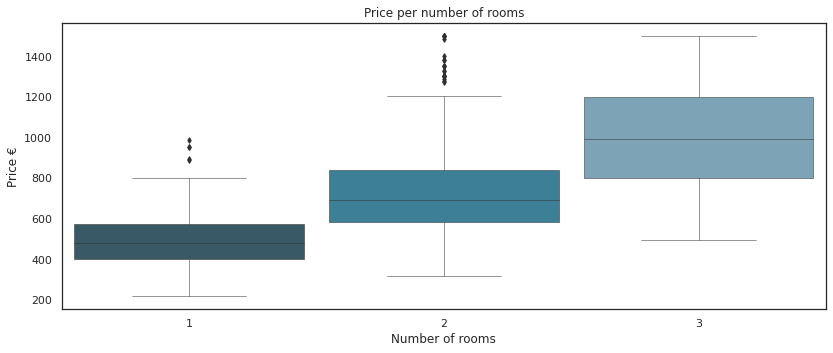

<Figure size 2304x576 with 0 Axes>

In [21]:
# Plotting the data to a boxplot
sns.set(rc={'figure.figsize':(13.7,5.27)})
sns.set_style("white")
sns.boxplot(x=rooms['Num_Rooms'], 
            y=rooms['Price'], 
            data=rooms,
            whis=1.5,
            saturation=0.65, 
            width=0.9,
            linewidth=0.5,
            fliersize=4,
            palette = 'PuBuGn_d')


plt.title('Price per number of rooms')
plt.ylabel('Price €')
plt.xlabel('Number of rooms')
plt.figure(figsize=(32,8))
plt.show()

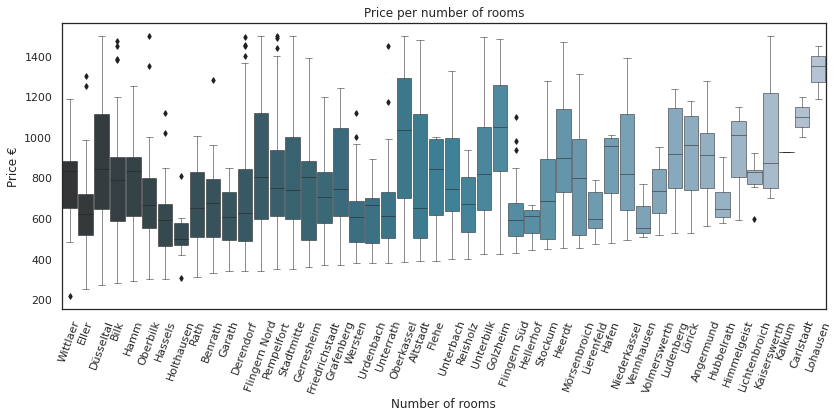

<Figure size 2448x576 with 0 Axes>

In [22]:
sns.set_style("white")
sns.boxplot(x=rooms['Borough'], 
            y=rooms['Price'], 
            data=rooms,
            whis=1.5,
            saturation=0.65, 
            width=0.9,
            linewidth=0.5,
            fliersize=4,
            palette = 'PuBuGn_d')

plt.xticks(rotation=70)
plt.title('Price per number of rooms')
plt.ylabel('Price €')
plt.xlabel('Number of rooms')
plt.figure(figsize=(34,8))
plt.show()

## Merging the information into a single table

After we have gained some insight of which type of information we are looking at, it is now time to keep merge the information into a single dataframe before we can move with the FourSquare API. 

The number of rooms and the general price needs to be grouped by borough, as that will be the level of detail that we are going to analyse, and to compare.

The question at hand is, how should this information be aggregated, using the total number, average values, or median?

As per the article https://www.manausa.com/blog/mean-median-mode-real-estate/, the median is often times the most common choice for the real estate sector, as it represents a value that is not so highly inluenced by the extreme values. In this case, we don't want that an appartment which might be on the high or low end of the facilities and price, might affect too much the data for the entire Borough.

Additional information can be found here: https://www.redfin.com/guides/median-sale-price-vs-average-sale-price

We will proceed then by getting the median price, median number of rooms, and total number of houses/appartments available per Borough.

In [23]:
rooms_grouped1 = rooms.groupby(['Borough'],as_index=False).median()
rooms_grouped2 = rooms.groupby(['Borough'],as_index=False).count()
rooms_grouped = pd.merge(rooms_grouped1, rooms_grouped2[['Borough','Num_Rooms']],on='Borough')
rooms_grouped.rename(columns={'Borough': 'Borough', 'Price': 'Price', 'Num_Rooms_x': 'Rooms', 'Num_Rooms_y':'Houses'}, inplace=True)

In [24]:
df_dusseldorf = df_dusseldorf.merge(rooms_grouped, how = 'left', on = 'Borough')
df_dusseldorf.fillna(0) # for the case of Boroughs with no appartments for the defined parameters 

District         Borough   latitude  longitude  Population    Price  \
0    Stadtbezirk 1        Altstadt  51.225912   6.773567        2453   650.00   
1    Stadtbezirk 1       Carlstadt  51.222142   6.773394        2281  1100.00   
2    Stadtbezirk 1      Stadtmitte  51.221939   6.784423       14958   740.00   
3    Stadtbezirk 1      Pempelfort  51.239601   6.779685       33282   750.00   
4    Stadtbezirk 1       Derendorf  51.244549   6.792249       20760   625.00   
5    Stadtbezirk 1        Golzheim  51.250794   6.759963       12861  1050.00   
6    Stadtbezirk 2    Flingern Süd  51.221009   6.810060       10413   592.00   
7    Stadtbezirk 2   Flingern Nord  51.231381   6.813238       25464   802.50   
8    Stadtbezirk 2       Düsseltal  51.237841   6.812116       28077   845.00   
9    Stadtbezirk 3  Friedrichstadt  51.213564   6.781700       19712   703.72   
10   Stadtbezirk 3       Unterbilk  51.210055   6.766965       19402   819.25   
11   Stadtbezirk 3           Hafen  51.217029   6.733576          82   955.00   
12   Stadtbezirk 3            Hamm  51.203572   6.738809        4496   834.50   
13   Stadtbezirk 3    Volmerswerth  51.188578   6.749010        2355   735.00   
14   Stadtbezirk 3            Bilk  51.202758   6.785101       41128   790.00   
15   Stadtbezirk 3        Oberbilk  51.213689   6.802428       30961   665.00   
16   Stadtbezirk 3           Flehe  51.192204   6.771713        2730   842.50   
17   Stadtbezirk 4      Oberkassel  51.229582   6.755450       19017  1035.00   
18   Stadtbezirk 4          Heerdt  51.232393   6.720114       12352   895.00   
19   Stadtbezirk 4          Lörick  51.245901   6.724363        7614   960.00   
20   Stadtbezirk 4    Niederkassel  51.240207   6.751985        6105   816.00   
21   Stadtbezirk 5         Stockum  51.264911   6.741647        5596   683.00   
22   Stadtbezirk 5        Lohausen  51.278641   6.731134        4121  1350.00   
23   Stadtbezirk 5    Kaiserswerth  51.301483   6.735517        8017   872.50   
24   Stadtbezirk 5        Wittlaer  51.319439   6.742058        8261   835.00   
25   Stadtbezirk 5       Angermund  51.328995   6.781416        6745   910.00   
26   Stadtbezirk 5          Kalkum  51.302451   6.758030        1955   925.00   
27   Stadtbezirk 6   Lichtenbroich  51.283871   6.795020        6218   827.60   
28   Stadtbezirk 6       Unterrath  51.273263   6.786978       21995   613.25   
29   Stadtbezirk 6            Rath  51.263905   6.820326       20412   650.00   
30   Stadtbezirk 6    Mörsenbroich  51.253381   6.811630       18123   801.01   
31   Stadtbezirk 7      Gerresheim  51.237686   6.860903       29874   806.00   
32   Stadtbezirk 7      Grafenberg  51.241093   6.832949        5844   745.00   
33   Stadtbezirk 7       Ludenberg  51.256357   6.866151        8081   915.00   
34   Stadtbezirk 7      Hubbelrath  51.256594   6.903954        1605   647.50   
35   Stadtbezirk 7       Knittkuhl  51.268682   6.870907        2062     0.00   
36   Stadtbezirk 8      Lierenfeld  51.208407   6.830470       11249   595.00   
37   Stadtbezirk 8           Eller  51.201253   6.837591       31547   620.00   
38   Stadtbezirk 8      Vennhausen  51.209553   6.858350       10722   550.00   
39   Stadtbezirk 8       Unterbach  51.203497   6.897832        7829   745.00   
40   Stadtbezirk 9         Wersten  51.189628   6.817777       27325   606.41   
41   Stadtbezirk 9     Himmelgeist  51.168337   6.805568        2063  1011.00   
42   Stadtbezirk 9      Holthausen  51.175998   6.833000       12890   500.00   
43   Stadtbezirk 9        Reisholz  51.177943   6.857714        3773   668.50   
44   Stadtbezirk 9         Benrath  51.163479   6.872734       16583   674.00   
45   Stadtbezirk 9       Urdenbach  51.147979   6.866360       10656   668.00   
46   Stadtbezirk 9           Itter  51.167891   6.817666        2400     0.00   
47   Stadtbezirk 9         Hassels  51.181953   6.866286       18586   590.00   
48  Stadtbezirk 10          Garath  51.14

In [25]:
df_dusseldorf[['Population','Price','Rooms','Houses']].corr()

Population     Price     Rooms    Houses
Population    1.000000 -0.282411 -0.145225  0.799237
Price        -0.282411  1.000000  0.663281 -0.076015
Rooms        -0.145225  0.663281  1.000000  0.014100
Houses        0.799237 -0.076015  0.014100  1.000000

In [26]:
# create a plain map of Düsseldorf
price_map = folium.Map(location=[latitude, longitude], zoom_start=11)

In [27]:
# create a numpy array of length 6 and has linear spacing from the minium total immigration to the maximum total immigration
threshold_scale = np.linspace(df_dusseldorf['Price'].min(),
                              df_dusseldorf['Price'].max(),
                              6, dtype=int)
threshold_scale = threshold_scale.tolist() # change the numpy array to a list
threshold_scale[-1] = threshold_scale[-1] + 1 # make sure that the last value of the list is greater than the maximum immigration
  
# generate choropleth map using the population of Düsseldorf for 2018
choropleth1 = folium.Choropleth(
    geo_data=dusseldorf_geo,
    name = 'choropleth',
    data = df_dusseldorf,
    columns=['Borough', 'Price'],
    key_on='feature.properties.Name',
    threshold_scale=threshold_scale,
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    highlight=True,
    legend_name='Median housing price - Düsseldorf'
).add_to(price_map)

# Let's add the Boroughs Labels
choropleth1.geojson.add_child(
    folium.features.GeoJsonTooltip(['Name'],labels=False)
)
                                                              
# Add Layer Control                                                                  
folium.LayerControl().add_to(price_map)
# display map
price_map

# 
## Using FourSquare to retrieve venues information


In [29]:
# Access Class file with Credentials
cred = credentials_oa_outlk.Credentials

print('Foursquare credentials imported from Class file.')

Foursquare credentials imported from Class file.


In [31]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
# Send the get request
#results = requests.get(url).json()
# results # -> Uncomment if needed

In [47]:
def getNearbyVenues(names, latitudes, longitudes, radius=1500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(cred.CLIENT_ID, cred.CLIENT_SECRET, cred.VERSION, lat, lng, radius, LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Borough', 
                  'Borough Latitude', 
                  'Borough Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [48]:
# Run previously created function on all Neighborhoods and save the result in a DataFrame
dusseldorf_venues = getNearbyVenues(names=df_dusseldorf['Borough'],
                                   latitudes=df_dusseldorf['latitude'],
                                   longitudes=df_dusseldorf['longitude']
                                  )

Altstadt
Carlstadt
Stadtmitte
Pempelfort
Derendorf
Golzheim
Flingern Süd
Flingern Nord
Düsseltal
Friedrichstadt
Unterbilk
Hafen
Hamm
Volmerswerth
Bilk
Oberbilk
Flehe
Oberkassel
Heerdt
Lörick
Niederkassel
Stockum
Lohausen
Kaiserswerth
Wittlaer
Angermund
Kalkum
Lichtenbroich
Unterrath
Rath
Mörsenbroich
Gerresheim
Grafenberg
Ludenberg
Hubbelrath
Knittkuhl
Lierenfeld
Eller
Vennhausen
Unterbach
Wersten
Himmelgeist
Holthausen
Reisholz
Benrath
Urdenbach
Itter
Hassels
Garath
Hellerhof


In [49]:
dusseldorf_venues.head()

Borough  Borough Latitude  Borough Longitude               Venue  \
0  Altstadt         51.225912           6.773567       Rösterei VIER   
1  Altstadt         51.225912           6.773567  Rheinuferpromenade   
2  Altstadt         51.225912           6.773567     Casita Mexicana   
3  Altstadt         51.225912           6.773567          Bar Chérie   
4  Altstadt         51.225912           6.773567        Elephant Bar   

   Venue Latitude  Venue Longitude      Venue Category  
0       51.225940         6.772294         Coffee Shop  
1       51.225275         6.770204    Pedestrian Plaza  
2       51.226676         6.775478  Mexican Restaurant  
3       51.226886         6.772424                 Bar  
4       51.226851         6.772636        Cocktail Bar

In [55]:
tt_venues = dusseldorf_venues.groupby('Borough').count()

In [73]:
tt_venues = tt_venues.sort_values(by=['Venue Category'], axis=0, ascending=True, inplace=False, kind='quicksort')

In [56]:
# Check how many different categories have been found 
print('There are {} uniques categories.'.format(len(dusseldorf_venues['Venue Category'].unique())))

There are 237 uniques categories.


In [53]:
# create map of Düsseldorf using latitude and longitude values
map_venues = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map 
for lat, lng, borough, category in zip(dusseldorf_venues['Venue Latitude'], dusseldorf_venues['Venue Longitude'], dusseldorf_venues['Borough'],dusseldorf_venues['Venue Category']):
    label = '{}, {}'.format(borough, category)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_venues)  
    
map_venues

In [54]:
dusseldorf_venues.to_csv('dusseldorf_venues.csv')

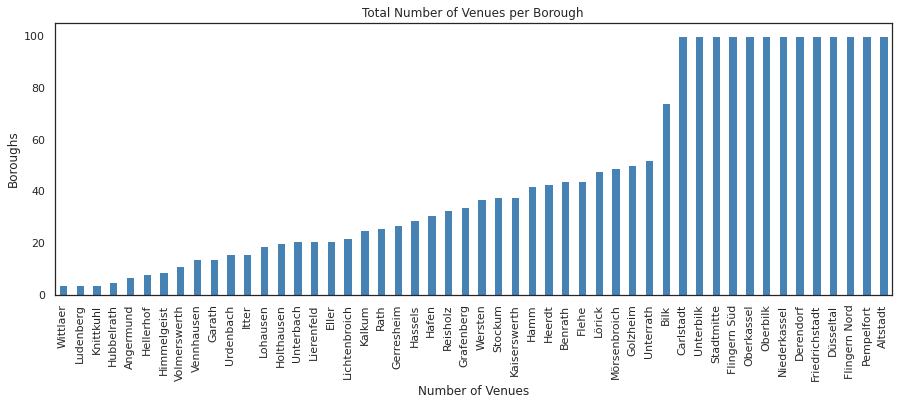

In [74]:
tt_venues['Venue Category'].plot(kind='bar', 
                                 figsize=(15, 5),
                                color = 'steelblue')

plt.title('Total Number of Venues per Borough') # add a title to the histogram
plt.ylabel('Boroughs') # add y-label
plt.xlabel('Number of Venues') # add x-label

plt.show()

In [57]:
tt_venues.head()

Borough Latitude  Borough Longitude  Venue  Venue Latitude  \
Borough                                                                 
Altstadt                100                100    100             100   
Angermund                 7                  7      7               7   
Benrath                  44                 44     44              44   
Bilk                     74                 74     74              74   
Carlstadt               100                100    100             100   

           Venue Longitude  Venue Category  
Borough                                     
Altstadt               100             100  
Angermund                7               7  
Benrath                 44              44  
Bilk                    74              74  
Carlstadt              100             100

In [71]:
# check the KMeans Elbow
####### https://blog.cambridgespark.com/how-to-determine-the-optimal-number-of-clusters-for-k-means-clustering-14f27070048f